## Practical Part

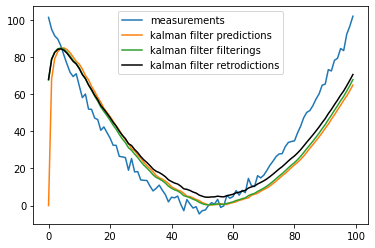

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter(object):
    def __init__(self, F = 0, H = 0, D = 0, R = 0, P = 0, x0 = 0, v = 0, W = 0):
        self.F = F
        self.H = H
        self.D = np.eye(F.shape[1]) if D is 0 else D
        self.R = np.eye(F.shape[1]) if R is 0 else R
        self.P = np.eye(F.shape[1]) if P is 0 else P
        self.x = np.zeros((F.shape[1], 1)) if x0 is 0 else x0
        self.v = np.eye(F.shape[1]) if v is 0 else v
        self.W = np.eye(F.shape[1]) if W is 0 else W

    def prediction(self):
        self.x = np.dot(self.F, self.x)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.D
        return self.x

    def filtering(self, z):
        self.v = z - np.dot(self.H, self.x)
        S = np.dot(self.H, np.dot(self.P, self.H.T)) + self.R
        self.W = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(self.W, self.v)
        self.P = self.P - np.dot(np.dot(self.W, S), self.W.T)

        #for the l = k-1
    def retrodiction(self, v, W, P_k_k1):
        P_k1_k1 = np.dot(np.dot(self.F, (P_k_k1 - self.D)), self.F.T) 
        W_k1_k = np.dot(np.dot(P_k1_k1, self.F.T), np.linalg.inv(P_k_k1))
        x_k_k1 = self.x - np.dot(W, v)
        x_k1_k1 = np.dot(np.linalg.inv(self.F), x_k_k1)
        
        self.x = x_k1_k1 + np.dot(W_k1_k, np.dot(W, v) )
        self.P = P_k1_k1 + np.dot(np.dot(W_k1_k, (self.P - P_k_k1)), W_k1_k.T)
        
def run(F, H, D, R):
	x = np.linspace(-10, 10, 100)
	measurements = x*x + np.random.normal(0, 2, 100)

	kalman = KalmanFilter(F = F, H = H, D = D, R = R)
	predictions = []
	filterings = []
	pred_p = []
	retros = []
	
	for z in measurements:
		predictions.append(np.dot(H,  kalman.prediction())[0])
		pred_p = kalman.P
		kalman.filtering(z)
		filterings.append(kalman.x[0])
		kalman.retrodiction(kalman.v, kalman.W, pred_p)
		retros.append(kalman.x[0])
	
	plt.plot(range(len(measurements)), measurements, label = 'measurements')
	plt.plot(range(len(predictions)), np.array(predictions), label = 'kalman filter predictions')
	plt.plot(range(len(filterings)), np.array(filterings), label = 'kalman filter filterings')
	plt.plot(range(len(retros)), np.array(retros), label = 'kalman filter retrodictions', color='black')
	plt.legend()
	plt.show()

if __name__ == '__main__':
	delta_t = 2.0/60
	F = np.array([[1, delta_t, 1/2*delta_t**2], 
                  [0, 1, delta_t], 
                  [0, 0, 1]])
	H = np.array([1, 0, 0]).reshape(1, 3)
	D = np.array([[1/4*delta_t**4, 1/2*delta_t**3, 1/2*delta_t**2], 
                  [1/2*delta_t**3, delta_t**2, delta_t], 
                  [1/2*delta_t**2, delta_t, 1]])
	R = np.array([0.5]).reshape(1, 1)
	run(F, H, D, R)

Here we also added retrodiction step as follows; \
The retrodiction formula is given in the slides. To look at the previous timestep l, we look at the l = k - 1 timestep. \
Then, formula becomes; \

N(x_k-1; x_k-1|k, P_k-1|k) <- N(x_k; x_k|k, P_k|k) \
x_k-1|k = x_k-1|k-1 + W_k-1|k * (x_k|k - x_k|k-1) \
P_k-1|k = P_k-1|k-1 + W_k-1|k * (P_k|k - P_k|k-1) * W_k-1|k_T \
W_k-1|k = P_k-1|k-1 * F_k|k-1_T * P_k|k-1_-1 \
\
Then, by using prediction and filtering formulas; \
x_k-1|k-1 = (x_k|k - W * v) * F_k|k-1_-1 + W_k-1|k * W * v \
P_k-1|k-1 = F_k|k-1_-1 * (P_k|k-1 - D_k|k-1) * F_k|k-1_-1_T + W_k-1|k * (P_k|k - P_k|k-1) * W_k-1|k_T \
W_k-1|k = P_k-1|k-1 * F_k|k-1_T * P_k|k-1_-1 \
\
Because we have prediction and filtering step before retrodiction step, we stored P_k|k-1 from prediciton and W and v from the filtering step for each value, then apply the retrodiction formula to get retro for the previous step l = k - 1

## Theoritical Part

## 1) GMTI Overview and MDV
\
"Ground moving-target indication (GMTI) radar imaging modes enable the remote detection and
characterization of nonstationary objects [3, 2, 1]. GMTI data is derived from range-Doppler maps
of the imaged scene, in which reflectivity is measured as a function of range r and range rate
dr/dt (i.e., the radial velocity of an imaged object with respect to the radar platform). All singlephase-center radar air-to-ground GMTI modes are characterized by a minimum detectable velocity
(MDV)—more precisely, a minimum detectable radial velocity, or a minimum detectable range
rate—below which motion of a discrete nonstationary target is indistinguishable from the relative
motion between the platform and the ground. Targets with radial velocities less than MDV are
typically overwhelmed by endoclutter ground returns, and are thus not generally detectable. The
MDV for a particular radar imaging scenario is a function of numerous parameters, including:

• Platform velocity $v$, relative to the ground;

• Platform altitude $h$, relative to the ground at scene center;

• Antenna elevation two-sided beamwidth $βe$;

• Antenna azimuth two-sided beamwidth $β$;

• Imaging depression angle $θ$ to scene center;

• Imaging squint angle $ψ$ (where $ψ = 0◦$ indicates a directly forward-looking geometry);

• Slant-plane range-bin spacing $δ_r$;

• Number of range bins in the image $N_r$.

These parameters impact MDV because they dictate the extent of the imaged scene on the ground
and the relative motion of different ground points across that extent, as described shortly. The
collective set of all imaged ground points comprises the endoclutter."

MDV is dependent on n imaging geometry, antenna characteristics, and platform velocity. General expression can be written: 

$MDV = v \left[\frac{(\frac{1}{cos\theta}sinψ sin\frac{\beta_\alpha}{2}+cosψcos\frac{\beta_\alpha}{2})(\tilde{r}_0+\frac{\triangle_\tilde{r}}{2})}{((\tilde{r}_0+\frac{\triangle_\tilde{r}}{2})^2+(hcos\frac{\beta_\alpha}{2})^2)^{1/2}} -cos\theta cosψ\right] (1) $

When $ψ=0^{\circ}$ it is called MDV forward looking geometry and thus taken as:

$
MDV_{fwd}=v(cos\theta_D-cos\theta)
$ (2) \\


When $ψ=90^{\circ}$ MDV is in broadside imagieng mode and it is:

$
MDV_{brd}=vsin\frac{\beta_\alpha}{2}
$ (3) \\

It is important to stress that this MDV is a minimum detectable radial velocity.


Note that $
MDV_{fwd}=v(cos\theta_D-cos\theta)
$ \\ holds only for $0^{\circ} ≤ ψ ≤ 90^{\circ}$,  it can be trivially extended
to hold for all other $ψ$. In particular, extension to $90^{\circ} < ψ ≤ 180^{\circ}$ simply requires replacing $ψ$ with
$(180^{\circ} − ψ)$; extension to $180^{\circ} < ψ ≤ 270^{\circ}$ simply requires replacing $ψ$ with $(ψ − 180^{\circ})$; extension
to $270^{\circ} <ψ< 360^{\circ}$ simply requires changing the sign of $ψ$.



"A general expression for MDV in an arbitrary imaging geometry is
provided by (1). In the special case of broadside imaging, this expression reduces approximately
to (3); in the special case of forward-looking imaging, this expression reduces approximately to
(2). Although comparison of these three equations reveals significant differences in the detailed
dependence of MDV on other parameters, they share an important fundamental similarity: regardless of imaging geometry, MDV is directly proportional to platform velocity. As such, the most
practical path to a smaller MDV in any operational scenario is usually a reduction in platform
velocity. This is especially true considering the various operational and physical limitations that
underlie the other terms in the MDV equations.

One important consideration not explicitly apparent from the MDV equations is the difference in
the direction of radial velocity inherent in each imaging geometry. In particular, because the radial
velocity direction is defined by the look direction, different absolute directions of target motion will
be inherently more or less detectable depending on the particular imaging geometry. Any selection
of imaging geometry for an operational scenario must thus include not only a consideration of the
MDV as in (1), but also a consideration of the prevalence or importance of different orientations
of target motion. For example, consider a scenario in which it is known in advance that all target
motion of interest will be oriented in a broadside direction relative to the platform velocity.7 Even
though a broadside imaging geometry will generally result in a much larger MDV than a forwardlooking geometry, use of a broadside imaging mode in this scenario might be inherently desirable
because a forward-looking scenario would result in a near-zero radial velocity for almost all object
trajectories of interest."

Resource: https://www.osti.gov/servlets/purl/1011708/

## 2) ---

## 3) Sequential Likelihood Ratio Test
\
"In typical tracking applications, the decisions between the alternatives must be made
as quickly as possible on average for given decision probabilities P0, P1. The decision
algorithm discussed below fulfills this requirement and is of enormous practical
importance. It is called Sequential Likelihood Ratio Test and was first proposed by
Abraham Wald [2–4, 8, 9].

The starting point for sequential decision-making in the context of track extraction
is the ratio of the conditional probabilities $p(h_1|Z^k)$ of $h_1$ being true given all data
have been processed appropriately and $p(h_0|Z^k)$ of $h_0$ being true given the sensor
data. If $p(h_1|Z^k)$ is close to One and $p(h_0|Z^k)$ close to Zero, the ratio is large, while
it is small if $p(h_1|Z^k)$ is close to Zero and $p(h_0|Z^k)$ close to One. If both hypotheses
are more or less equally probable, the ratio is of an intermediate size. According to
Bayes’ Theorem, we obtain:

$\frac{p(h_1|Z^k)}{p(h_0|Z^k)}=\frac{p(Z^k|h_1)}{p(Z^k|h_0)}\frac{p(h_1)}{p(h_0)}$

Since the a priori probabilities $p(h_1)$ and $p(h_0)$ are in most applications assumed to be equal, this defines a test function, which is called likelihood ratio:

$LR(k)=\frac{p(Z^k| h_1)}{p(Z^k| h_0)}$

and can be calculated iteratively by exploiting the underlying object evolution and sensor models $p(X_k |X_k−1)$ and $p(Z_k |X_k )$.

An intuitively plausible sequential test procedure starts with a time window of
length $k = 1$ and iteratively calculates the test function $LR(k)$ until a decision can
be made. At each step of this iteration the likelihood ratio is compared with two
thresholds $A$ and $B$:

$LR(k) < A$, accept the hypothesis $h_0$ (i.e. no object existent) \\
for $LR(k) > B$, accept the hypothesis $h_1$ (i.e. an object exists) \\
$A < LR(k) < B$, expect new data $Z_{k+1}$, repeat the test with $LR(k + 1)$."

Resource: W. Koch (2014), Tracking and Sensor Data Fusion, Springer mathematical Engineering Series, page 97.

## Bonus)

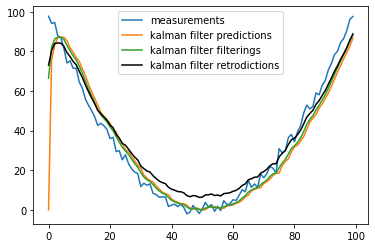

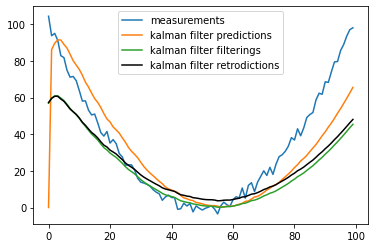

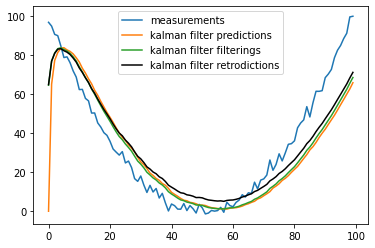

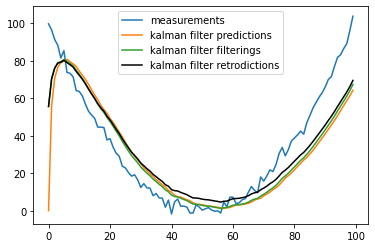

In [2]:
if __name__ == '__main__':
	delta_t = 2.0/60
	F2 = 1.03*np.array([[1, delta_t, 1/2*delta_t**2], 
                  [0, 1, delta_t], 
                  [0, 0, 1]])
	run(F2, H, D, R)
	H2 = 1.5*np.array([1, 0, 0]).reshape(1, 3)
	run(F, H2, D, R)
	D2 = 2*np.array([[1/4*delta_t**4, 1/2*delta_t**3, 1/2*delta_t**2], 
                  [1/2*delta_t**3, delta_t**2, delta_t], 
                  [1/2*delta_t**2, delta_t, 1]])
	run(F, H, D2, R)
	R2 = np.array([0.8]).reshape(1, 1)
	run(F, H, D, R2)

Here, if we change some parameters like F, H, D, R; we can see the difference they apply. \
If we change F slightly, it can improve the filtering and retrodiction performance, however if we make change too much, then result will be defected. \
If we change H, prediction will be closer to measurements but all measurement, prediction and retrodiction values become worse. \
If we change D and R for even 50%, it will not affecr the results much at all. \
\
Yet, we can still take better results if the parameters are applied more sutiable